## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
try:
    from google.colab import drive

    IN_COLAB = True
    drive.mount('/content/drive')
    !pip install -q python-dotenv shap  
    %cd /content/drive/MyDrive/Best ML model ever/

except:
    IN_COLAB = False
    # Set working directory
    %cd ..
!pwd

/mnt/d/Google Drive/Best ML model ever
/mnt/d/Google Drive/Best ML model ever


In [2]:
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore") 
shap.initjs()


## Load the data

In [3]:
path_data = "input/dri_wat_pot_folds.csv"

df = pd.read_csv(path_data)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
nb_tot_rows = df.shape[0]
df_features = df.drop("Potability", axis=1)
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,kfold
0,6.799376,239.057680,7986.493239,10.365680,419.881175,373.232137,18.828594,43.440644,3.819985,1,3
1,5.498515,180.825114,21542.830030,6.707095,352.250711,419.512958,13.183432,68.904370,3.074815,1,2
2,7.386582,191.585566,26351.903770,8.426161,NaN,505.187929,18.925674,72.649614,3.791373,1,4
3,6.783888,193.653581,13677.106440,5.171454,323.728663,477.854687,15.056064,NaN,3.250022,0,1
4,7.137429,210.502749,17506.608800,7.304928,301.642004,304.239481,13.076007,64.230942,2.964181,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2615,6.578681,203.408816,22374.824910,6.248929,399.617217,547.702137,12.097920,71.338489,4.292042,1,1
2616,8.922380,278.619448,21963.476000,8.105638,334.053693,385.874799,8.803475,NaN,5.821826,1,1
2617,NaN,233.063426,36640.371370,10.000218,435.115189,337.664412,16.635476,61.073710,4.849755,1,2
2618,NaN,206.318342,18752.269680,8.202453,344.589628,510.487880,5.362371,61.911364,3.293553,0,0


# Predict some results

In [4]:
from src import predict_one_sample

X_test = [6.06335479e+00, 1.60767311e+02, 1.47751456e+04, 7.48410365e+00,
    3.05828553e+02, 3.27270239e+02, 1.23090160e+01, 6.90384539e+01,
    3.46733692e+00]
pred, pred_probas, pre_pipeline, clf = predict_one_sample(X_test, "stacking")
print(pred, pred_probas)

0 [0.67939328 0.32060672]


# Shap values

In [5]:
pre_pipeline

src.model_dispatcher.StackingPrePipeline

In [24]:
# Summarize the training set to accelerate analysis
df_train = df.drop(columns=["Potability", "kfold"], errors="ignore").dropna()
cols = df_train.columns

# preprocess
df_train, _ = pre_pipeline.transform(df_train)
cols = list(cols) + [ str(i) for i in range(df_train.shape[1]- len(cols)) ]


df_train_summary = shap.kmeans(df_train, 100)
df_explained = pd.DataFrame(df_train, columns=cols)
df_explained = df_explained.sample(1000)
print(df_explained.shape)
df_explained.head()

(1000, 9)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
183,7.543931,192.234541,24227.96114,7.241343,336.151050,369.427699,18.188873,70.588507,3.703191
1583,4.238283,134.889510,29344.84448,8.180874,351.237362,402.427174,12.427378,83.762653,3.787426
1378,8.394397,187.643411,10603.09802,7.840261,352.835640,376.241146,13.374831,58.950002,2.833901
2453,7.096047,221.508245,17240.02106,9.181473,322.616878,442.543600,16.576200,78.122091,4.785637
641,7.436783,208.094004,28544.61629,6.500053,339.023898,522.793730,17.115276,65.311277,3.727664


In [25]:
explainer = shap.KernelExplainer(clf.predict_proba, df_train_summary)

### Explain a single prediction

In [26]:
shap.initjs()
shap_values = explainer.shap_values(df_explained.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], df_explained.iloc[0,:])

### Explain all the predictions

In [27]:
shap_values = explainer.shap_values(df_explained.values)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], df_explained)

In [29]:
df_explained.shape

(1000, 9)

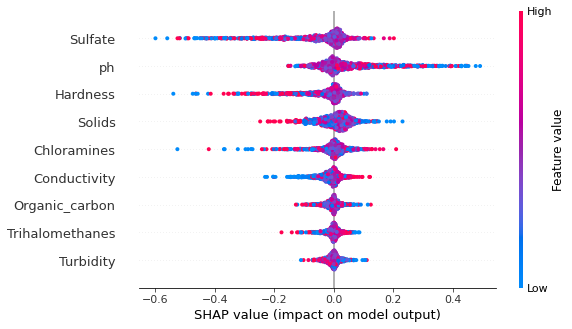

In [30]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], df_explained)

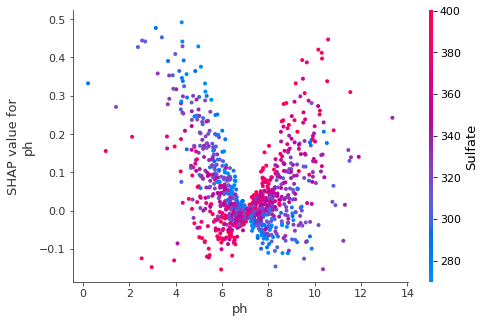

In [31]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('ph', shap_values[0], df_explained)

# References
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d